In [1]:
import time
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import lasagne
import theano
import theano.tensor as T
from PIL import Image

In [2]:
def table(x, y):
    tab={'TP':len([tp for tp in zip(x, y) if tp[0]==1 and tp[1]==1]),
        'FP':len([fp for fp in zip(x, y) if fp[0]==1 and fp[1]==0]),
        'FN':len([fn for fn in zip(x, y) if fn[0]==0 and fn[1]==1]),
        'TN':len([tn for tn in zip(x, y) if tn[0]==0 and tn[1]==0])}
    return tab

In [3]:
def mat_corr(tab):
    a = tab['TP']*tab['TN'] - tab['FN']*tab['FP']
    if a == 0.0:
        return 0
    b = ((tab['TP']+tab['FN'])*(tab['TP']+tab['FP'])*(tab['TN']+tab['FP'])*(tab['TN']+tab['FN']))**0.5
    return a/b

In [4]:
def load_data_NN(filename=None, rand_st=42):
    df = pd.read_csv(filename, sep=';')
    X, y = np.array(df.image), np.array(df.label)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = rand_st)
    #return X_train, y_train, X_val, y_val, X_test, y_test
    return X_train, y_train, X_test, y_test

In [5]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [6]:
def build_cnn(input_var=None, dropout=False):
    network = lasagne.layers.InputLayer(shape=(None, 1, 100, 100), input_var=input_var)
    
    network = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(network, num_filters=16, filter_size=(3,3),
                                        nonlinearity=lasagne.nonlinearities.leaky_rectify,
                                        W=lasagne.init.Normal()))
    network = network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    network = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3,3),
                                        nonlinearity=lasagne.nonlinearities.leaky_rectify,
                                        W=lasagne.init.Normal()))
    network = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3,3),
                                        nonlinearity=lasagne.nonlinearities.leaky_rectify,
                                        W=lasagne.init.Normal()))
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(network, num_filters=64, filter_size=(3,3),
                                        nonlinearity=lasagne.nonlinearities.leaky_rectify,
                                        W=lasagne.init.Normal()))
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    if dropout:
        network = lasagne.layers.dropout(network, p=0.5)
        
    network = lasagne.layers.batch_norm(lasagne.layers.DenseLayer(network, 
                                        num_units=32,
                                        nonlinearity=lasagne.nonlinearities.leaky_rectify,
                                        W=lasagne.init.Normal()))
    if dropout:
        network = lasagne.layers.dropout(network, p=0.5)
    
    network = lasagne.layers.DenseLayer(network,
                                        num_units=1,
                                        nonlinearity=lasagne.nonlinearities.sigmoid)
    return network

In [7]:
print('Loading data...')
X_train, y_train, X_val, y_val = load_data_NN('data100.csv')
T_loss = []
V_loss = []
Cor1 = []
Cor2 = []

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

print("Building model and compiling functions...")
network = build_cnn(input_var, dropout=True)
#layers = lasagne.layers.get_all_layers(network)
#l_reg1 = layers[13]
#l_reg2 = layers[-1]
#l2_pen1 = lasagne.regularization.regularize_layer_params(l_reg1, lasagne.regularization.l2)*0.1
#l2_pen2 = lasagne.regularization.regularize_layer_params(l_reg2, lasagne.regularization.l2)*0.1
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.binary_crossentropy(prediction, target_var)
loss = loss.mean()# + l2_pen1 + l2_pen2
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.binary_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], test_loss)
f = theano.function([input_var], test_prediction)

print("Starting training...")

num_epochs = 300
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 20, shuffle=True):
        inputs, targets = batch
        targets = np.array(targets, dtype=np.int32)
        inputs = np.array([np.array(Image.open(image).convert('L')) for image in inputs])
        inputs = inputs.reshape(-1, 1, 100, 100)
        inputs = inputs / np.float32(255)
        train_err += train_fn(inputs, targets)
        train_batches += 1
        
    val_err = 0
    val_batches = 0
    mat_corr1 = 0.0
    mat_corr2 = 0.0
    for batch in iterate_minibatches(X_val, y_val, 20, shuffle=False):
        inputs, targets = batch
        targets = np.array(targets, dtype=np.int32)
        inputs = np.array([np.array(Image.open(image).convert('L')) for image in inputs])
        inputs = inputs.reshape(-1, 1, 100, 100)
        inputs = inputs / np.float32(255)
        err = val_fn(inputs, targets)
        val_err += err
        val_batches += 1
        arr1 = np.array(f(inputs).ravel() > 0.5, dtype=np.int32)
        arr2 = np.array(f(inputs).ravel() > 0.8, dtype=np.int32)
        tab1 = table(arr1, targets)
        tab2 = table(arr2, targets)
        mat_corr1 += mat_corr(tab1)
        mat_corr2 += mat_corr(tab2)
        
    T_loss.append(train_err / train_batches)
    V_loss.append(val_err / val_batches)
    Cor1.append(mat_corr1 / val_batches)
    Cor2.append(mat_corr2 / val_batches)
    
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(T_loss[-1]))
    print("  validation loss:\t\t{:.6f}".format(V_loss[-1]))
    print('  Mat_corr_1:\t', Cor1[-1])
    print('  Mat_corr_2:\t', Cor2[-1])

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 300 took 212.645s
  training loss:		0.676082
  validation loss:		0.705620
  Mat_corr_1:	 0.13596917444918763
  Mat_corr_2:	 0.04335224342109563
Epoch 2 of 300 took 210.873s
  training loss:		0.640362
  validation loss:		0.595140
  Mat_corr_1:	 0.4012199289052787
  Mat_corr_2:	 0.27124804885299086


KeyboardInterrupt: 

In [8]:
# Optionally, you could now dump the network weights to a file like this:
import pickle
np.savez('model1.npz', *lasagne.layers.get_all_param_values(network))
L = [T_loss, V_loss, Cor1, Cor2]
with open('info_train1', 'wb') as f:
    pickle.dump(L, f, pickle.HIGHEST_PROTOCOL)
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)

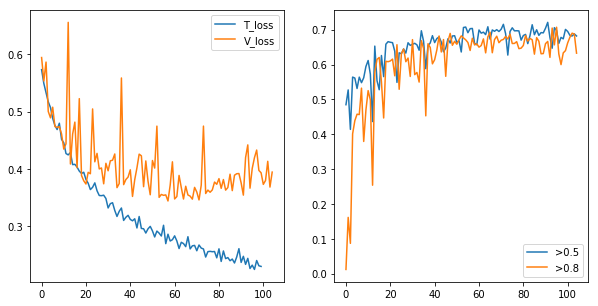

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(0,len(T_loss)), T_loss, label='T_loss')
plt.plot(np.arange(0,len(V_loss)), V_loss, label='V_loss')
plt.legend()
plt.subplot(122)
plt.plot(np.arange(0,len(Cor1)), Cor1, label='>0.5')
plt.plot(np.arange(0,len(Cor2)), Cor2, label='>0.8')
plt.legend()

In [3]:
input_var = T.tensor4('inputs')
network = build_cnn(input_var)
with np.load('model1.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

In [9]:
out = lasagne.layers.get_output(network, deterministic=True)
f = theano.function([input_var], out)

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,640)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 480)
cap.set(cv2.CAP_PROP_FPS, 60)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    im  = PIL.Image.fromarray(gray)
    im = np.array(im.resize((100,100), Image.ANTIALIAS)) / np.float32(255)
    im = im.reshape(-1, 1, 100, 100)
    predict = f(im).ravel()[0]
    print(kl)
    if predict > 0.5:
        gray = cv2.putText(gray, 'YES', (150,150), cv2.FONT_HERSHEY_SIMPLEX, 10, 255, 10)
    else:
        gray = cv2.putText(gray, 'NO', (150,150), cv2.FONT_HERSHEY_SIMPLEX, 10, 255, 10)
    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

0.537648117641
0.539812130738
0.540045180349
0.536029106582
0.532557582355
0.534012639152
0.530984095561
0.530583197306
0.532628748349
0.533291678552
0.536440364514
0.538572691286
0.536016427047
0.535111502205
0.532764888525
0.532676184591
0.532206229199
0.535990545649
0.535154666247
0.538251001518
0.536814056764
0.533149679933
0.534083952022
0.53136380017
0.52569102808
0.520881159584
0.523552448887
0.521308913363
0.521740015139
0.522137866969
0.520654347636
0.521672712278
0.52355701536
0.520425011418
0.522038355287
0.522166444019
0.52577095743
0.527008665286
0.524445273733
0.523172396603
0.5214077914
0.526165567278
0.523813716294
0.523494308388
0.527777579045
0.526158424814
0.525778687403
0.526435476672
0.529165117725
0.528930293996
0.533895924146
0.532134174026
0.532479094821
0.536106399559
0.536397169315
0.538471195205
0.539190864016
0.53942041191
0.539430472306
0.540007746175
0.54262557946
0.543569387281
0.540886450319
0.545952956801
0.543935495748
0.54623191494
0.545825214048
0.54